# Adjusting PC-SAFT binary $k_{ij}$ parameter 

## Goal

- Read in experimental data for binary VLEs
- Use the `DataSet`, `Loss` and `Estimator` objects to store and work with experimental data.
- Define a `cost` function that will be used with `scipy.optimize.least_squares`.
- Run the optimization.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import seaborn as sns
from si_units import BAR, KELVIN, KILOGRAM, METER

from feos.eos import EquationOfState, PhaseDiagram
from feos.pcsaft import Identifier, IdentifierOption, PcSaftParameters, PcSaftRecord, PureRecord
from feos.eos.estimator import Estimator, Loss, DataSet, Phase

sns.set_context('talk')
sns.set_palette('Dark2')
sns.set_style('ticks')
colors = sns.palettes.color_palette('Dark2', 5)
plt.rcParams['figure.figsize'] = [12,7]

## Defining a cost function

We will solve the fitting-problem using `scipy`'s `least_squares` solver, which requires a function to calculate the cost or residuals. The first argument of this function must be the parameter vector that's being optimized. Therefore, it is necessary to define this function in Python before working with `least_squares`.

To simplify the process, we create two functions:

- `eos_from_kij`: This function constructs the equation of state based on the current $k_{ij}$ value. Since FeO$_\text{s}$ does not allow mutation of an existing `EquationOfState` object, generating a new equation of state is necessary. We can use this function later to generate the equation of state for the final parameter.
- `cost`: Taking the parameter and estimator (discussed below) as inputs, this function builds the equation of state, calculates the cost of the current model, and returns the result.

In [2]:
def eos_from_kij(kij):
    """Returns equation of state (PC-SAFT) for current kij."""
    global parameters
    p = PcSaftParameters.new_binary(parameters.pure_records, kij)
    return EquationOfState.pcsaft(p)

def cost(kij, estimator):
    """Calculates cost function for current parameters."""
    return estimator.cost(eos_from_kij(kij))

### Utility function - plot experiment and prediciton

The following function takes experimental data and a $k_{ij}$ value as input and produces a phase diagram depicting both experiment and prediction from the equation of state.

In [3]:
def plot_comparison(data, kij):
    """Generates a plot for each experimental isotherm and PC-SAFT estimate"""
    for i, (temperature, isotherm) in enumerate(data.groupby('t')):
        # plot experiment
        plt.plot(
            isotherm.x1, isotherm.p, 
            color=colors[i], marker='s', linestyle="",
            label=f"T = {temperature} K"
        )
        plt.plot(
            isotherm.y1, isotherm.p, 
            color=colors[i], marker='s', linestyle="",
        )

        # plot PC-SAFT
        vle = PhaseDiagram.binary_vle(
            eos_from_kij(kij), 
            temperature*KELVIN, 
            npoints=25
        )
        plt.plot(
            vle.liquid.molefracs[:, 0], vle.liquid.pressure / BAR,
            color=colors[i]
        )
        plt.plot(
            vle.vapor.molefracs[:, 0], vle.vapor.pressure / BAR,
            color=colors[i]
        )

    plt.xlim(0, 1)
    plt.ylim(0.1, 0.8)
    plt.xlabel(r"$x_1, y_1$")
    plt.ylabel(r"$p$ / bar")
    plt.legend(
        frameon=False, 
        title=r"$k_{ij} = $" + f"{kij:8.4f}",
        bbox_to_anchor=[1,1]
    );

## Experimental data

We are using experimental data extracted from the openly available supplementary information of the work of [Jaubert et al.](https://doi.org/10.1021/acs.iecr.0c01734). We will be using the binary mixture of 2-propanol and 2,2,4-trimethylpentane as example.

In [4]:
data = pd.read_csv("data/binary_vle.csv", delimiter="\t")

## Compare to PC-SAFT prediction ($k_{ij} = 0.0$)

Before we start, let's inspect how well PC-SAFT predicts this binary mixture. We will use the parameters by Esper et al.

In [5]:
parameters = PcSaftParameters.from_json(["2-propanol", "2,2,4-trimethylpentane"], "../../../parameters/pcsaft/esper2023.json")
pcsaft = EquationOfState.pcsaft(parameters)
parameters

|component|molarweight|$m$|$\sigma$|$\varepsilon$|$\mu$|$Q$|$\kappa_{AB}$|$\varepsilon_{AB}$|$N_A$|$N_B$|$N_C$|
|-|-|-|-|-|-|-|-|-|-|-|-|
|2-propanol|60.058|3.95902|2.93004|198.97045|-|-|0.03508|1898.4667|1|1|0|
|2,2,4-trimethylpentane|114.141|3.13984|4.08786|249.78239|-|-|-|-|0|0|0|

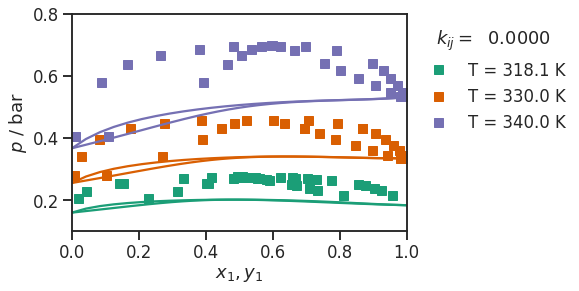

In [6]:
plot_comparison(data, 0.0)

## Build `DataSet` objects

There is definitely room for improvement. Let's start with the `DataSet` object available in FeO$_\text{s}$.
A `DataSet` serves as a storage unit for experimental data and also defines a cost function for that specific data set.
Below, we will use the `DataSet.binary_phase_diagram` constructor and provide temperature, pressures, as well as liquid and vapor mole fractions.
The `binary_phase_diagram` data set is one of three options - the others will be discussed below.
Importantly, this data set will use a *distance* criterion as cost function. I.e. the length of the vector that is orthogonal to the phase envelope and that connects to the experimental datum. 

Each `DataSet` with this constructor has to contain data for a *single* pressure or temperature. Here, we group the experimental data according to temperatures and end up with 3 `DataSet` objects - one for each temperature.

In [7]:
isotherms = [
    DataSet.binary_phase_diagram(
        temperature*KELVIN, 
        isotherm.p.values * BAR, 
        isotherm.x1.values,
        isotherm.y1.values,
        npoints=40
    ) 
    for temperature, isotherm in data.groupby('t')
]

## Build `Estimator` object

Next, we use the `Estimator` object. The `Estimator` is a wrapper around multiple `DataSet`s and provides a convenient way to calculate the cost function of multiple `DataSet`s in one function call. Furthermore, we can use the `Estimator` to define weights between `DataSet`s and `Loss` objects for robust regression. In this example, all isotherms have the same weights (each weight is unity) and we perform a simple least squares optimization an thus use `Loss.linear`.

In [8]:
estimator = Estimator(isotherms, weights=[1]*3, losses=[Loss.linear()]*3)

## Run the optimization

With that, we can perform the optimization. We set the initial $k_{ij}$ value to zero, the bounds to `[-0.5, 0.5]` and we provide the estimator as additional argument to the `cost` function defined on top of this notebook. Once the optimization successfully finished, we can inspect the results.

In [9]:
%%time
initial_kij = [0.0]
fitted_kij = least_squares(cost, initial_kij, bounds=[-0.5, 0.5], args=(estimator,), verbose=2).x

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.2773e-05                                    9.16e-04    
       1              2         2.5544e-06      5.02e-05       4.13e-02       1.85e-04    
       2              3         6.8459e-07      1.87e-06       8.62e-03       1.62e-05    
       3              4         6.6847e-07      1.61e-08       8.77e-04       4.85e-07    
       4              5         6.6846e-07      1.54e-11       2.79e-05       4.18e-08    
       5              6         6.6846e-07      1.11e-13       2.41e-06       4.95e-10    
`gtol` termination condition is satisfied.
Function evaluations 6, initial cost 5.2773e-05, final cost 6.6846e-07, first-order optimality 4.95e-10.
CPU times: user 470 ms, sys: 1.99 ms, total: 472 ms
Wall time: 474 ms


/tmp/ipykernel_2500868/2373019003.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = PcSaftParameters.new_binary(parameters.pure_records, kij)


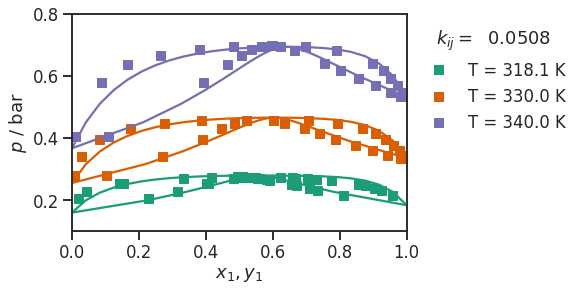

In [10]:
plot_comparison(data, fitted_kij[0])

# Using other target functions

In the above example, we used `DataSet.binary_phase_diagram` which used the distance criterion as cost. In FeO$_{s}$, we provide two additional cost functions: difference in chemical potentials and difference in pressures.

## Difference in chemical potentials given $T, p, x_1, y_1$

The cost function of `DataSet.binary_vle_chemical_potential` is defined as difference of the chemical potentials of the vapor and liquid phase (for each substance) for given $\{T, p, \bar{y}\}$ and $\{T, p, \bar{x}\}$, respectively. 

In [11]:
isotherms = [
    DataSet.binary_vle_chemical_potential(
        np.array([temperature]*len(isotherm)) *KELVIN, 
        isotherm.p.values * BAR, 
        isotherm.x1.values,
        isotherm.y1.values,
    ) 
    for temperature, isotherm in data.groupby('t')
]
estimator_mu = Estimator(isotherms, weights=[1]*3, losses=[Loss.linear()]*3)

In [12]:
%%time
initial_kij = [0.0] # 
fitted_kij_mu = least_squares(cost, initial_kij, bounds=[-0.5, 0.5], args=(estimator_mu,), verbose=2).x

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2674e-03                                    2.39e-02    
       1              2         7.9041e-05      1.19e-03       4.56e-02       2.07e-03    
       2              3         6.7858e-05      1.12e-05       4.85e-03       2.37e-05    
       3              4         6.7856e-05      1.49e-09       5.67e-05       9.92e-09    
`gtol` termination condition is satisfied.
Function evaluations 4, initial cost 1.2674e-03, final cost 6.7856e-05, first-order optimality 9.92e-09.
CPU times: user 21.9 ms, sys: 0 ns, total: 21.9 ms
Wall time: 21.1 ms


/tmp/ipykernel_2500868/2373019003.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = PcSaftParameters.new_binary(parameters.pure_records, kij)


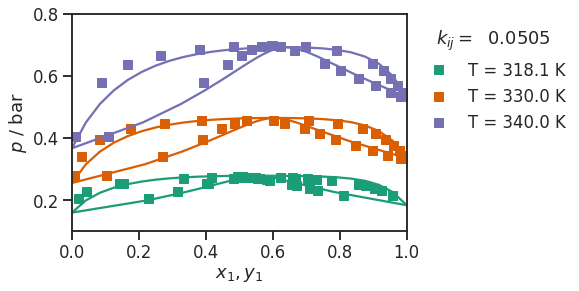

In [13]:
plot_comparison(data, fitted_kij_mu[0])

## Difference in pressure given $\{T, p, x_i\}$ or $\{T, p, y_i\}$

`DataSet.binary_vle_pressure` uses temperatures, pressures, mole fractions and a flag for the phase (`Phase.Liquid` or `Phase.Vapor`) as input. Depending on the phase it calculates the dew or bubble pressure for each data point. The cost is the difference between the dew/bubble pressure and the provided (input) pressure.

Since we have information about both phases in our experimental data, we can construct 6 `DataSet`s (3 isotherms for 2 phases). Alternatively, we could have splitted the data into two `DataSet`s, one for each phase.

In [14]:
isotherms = [
    [
        DataSet.binary_vle_pressure(
            np.array([temperature]*len(isotherm)) *KELVIN, 
            isotherm.p.values * BAR, 
            isotherm.x1.values,
            Phase.Liquid
        ),
        DataSet.binary_vle_pressure(
            np.array([temperature]*len(isotherm)) *KELVIN, 
            isotherm.p.values * BAR, 
            isotherm.y1.values,
            Phase.Vapor
        ),
    ]
    for temperature, isotherm in data.groupby('t')
]

from itertools import chain
estimator_p = Estimator(list(chain.from_iterable(isotherms)), weights=[1]*6, losses=[Loss.linear()]*6)

In [15]:
%%time
initial_kij = [0.0] # 
fitted_kij_p = least_squares(cost, initial_kij, bounds=[-0.5, 0.5], args=(estimator_p,), verbose=2).x

/tmp/ipykernel_2500868/2373019003.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = PcSaftParameters.new_binary(parameters.pure_records, kij)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2123e-04                                    3.56e-03    
       1              2         8.2940e-06      2.13e-04       5.17e-02       1.51e-04    
       2              3         8.1416e-06      1.52e-07       1.13e-03       1.64e-06    
       3              4         8.1416e-06      2.73e-11       1.54e-05       4.11e-08    
       4              5         8.1416e-06      1.27e-14       3.15e-07       1.09e-09    
`gtol` termination condition is satisfied.
Function evaluations 5, initial cost 2.2123e-04, final cost 8.1416e-06, first-order optimality 1.09e-09.
CPU times: user 875 ms, sys: 7.91 ms, total: 883 ms
Wall time: 880 ms


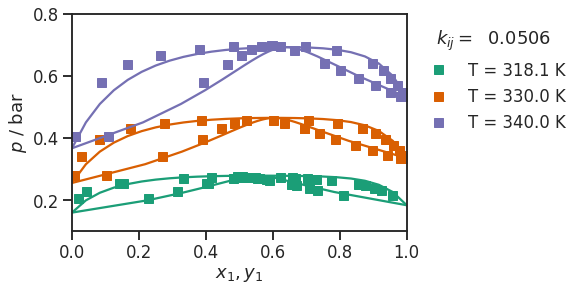

In [16]:
plot_comparison(data, fitted_kij_p[0])

# Evaluating the results

We end up with 3 slightly different values for $k_{ij}$.
Note that comparing the MARD values of the three different ways we created `DataSet`s is not very informative since each contains a different property that is predicted. E.g. the MARD of the chemical potential cost function contains the differences of chemical potentials of both phases and compares these values to zero. Finally, note that the MARD is not the metric that is minimized.

In [17]:
print("Adjusted k_ij parameters and MARDs")

mard_distance = estimator.mean_absolute_relative_difference(eos_from_kij(fitted_kij)) * 100
mard_mu = estimator_mu.mean_absolute_relative_difference(eos_from_kij(fitted_kij_mu)) * 100
mard_p = estimator_p.mean_absolute_relative_difference(eos_from_kij(fitted_kij_p)) * 100
print(f"MARD (distance,   k_ij = {fitted_kij[0]:>6.4}) = {mard_distance.mean():>8.4} %")
print(f"MARD (chem. pot., k_ij = {fitted_kij_mu[0]:>6.4}) = {mard_mu.mean():>8.4} %")
print(f"MARD (pressure,   k_ij = {fitted_kij_p[0]:>6.4}) = {mard_p.mean():>8.4} %")

Adjusted k_ij parameters and MARDs
MARD (distance,   k_ij = 0.05082) =    1.302 %
MARD (chem. pot., k_ij = 0.05048) =    6.181 %
MARD (pressure,   k_ij = 0.05056) =    3.092 %


/tmp/ipykernel_2500868/2373019003.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = PcSaftParameters.new_binary(parameters.pure_records, kij)


# Summary

- The `Estimator` object in FeO$_\text{s}$ allows the collection of `DataSet` objects for adjusting parameters.
  - The `Estimator` takes a list of `DataSet` objects, weights, and `Loss` objects as inputs.
  - It calculates the cost of a model where the cost function can be different for each `DataSet`.
- To work with `scipy`'s `least_squares` solver, a cost function is required.
  - Two functions, `eos_from_kij` and `cost`, are built for this purpose.
  - `eos_from_kij` constructs the parameters and equation of state for the current $k_{ij}$ value.
  - `cost` calculates and returns the cost of the current model based on the parameters and estimator.
- An initial parameter guess and bounds are necessary for parameter adjustment.
- The `Estimator.mean_absolute_relative_difference` is probably is not the most instructive metric to judge the quality of the adjusted parameter. It's straight forward to calculate MARDs of composition or pressure/temperature with FeO$_\text{s}$ which can be used to get an idea of the quality of the adjustment.